# Importing RDKit and other necessary packages

In [2]:
import os
import sys

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolfiles
from rdkit.Chem import Descriptors, Crippen, QED
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True


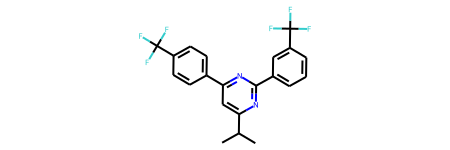

In [3]:
mol = Chem.MolFromSmiles(' C ( C ) ( C ) c 1 c c ( - c 2 c c c ( C ( F ) ( F ) F ) c c 2 ) n c ( - c 2 c c c c ( C ( F ) ( F ) F ) c 2 ) n 1'.replace(' ', ''))
mol

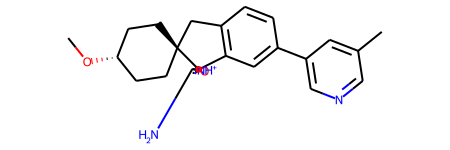

In [4]:
mol = Chem.MolFromSmiles('CO[C@@H]1CC[C@@]2(CC1)Cc1c([C@]32COC(=[NH+]3)N)cc(cc1)c1cncc(c1)C')
mol

In [5]:
from rdkit.Chem import AllChem
from rdkit import Chem, DataStructs

In [6]:
from molvs import standardize_smiles

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

# Defining functions for computing physicochemical properties

In [8]:
def lipsinki_properties(samples_df):
    hd = []
    ha = []
    rb = []
    tpsa = []
    for s in samples_df['smiles']:
        try:
            m = Chem.MolFromSmiles(s)
            hd_s = Chem.Lipinski.NumHDonors(m)
            ha_s = Chem.Lipinski.NumHAcceptors(m)
            rb_s = Chem.Lipinski.NumRotatableBonds(m)
            tpsa_s = Chem.Descriptors.TPSA(m)
            hd.append(hd_s)
            ha.append(ha_s)
            rb.append(rb_s)
            tpsa.append(tpsa_s)
        except:
            print(s)
            continue
    return hd, ha, rb, tpsa


def molecular_properties(samples_df):
    mw = []
    logp = []
    qed = []
    for s in samples_df['smiles']:
        try:
            m = Chem.MolFromSmiles(s)
            mw_s = Descriptors.ExactMolWt(m)
            logp_s = Crippen.MolLogP(m, includeHs=True)
            qed_s = QED.qed(m)
            mw.append(mw_s)
            logp.append(logp_s)
            qed.append(qed_s)
        except:
            print(s)
            continue
    return mw, logp, qed


"""Computing Synthetic Accessibility Score (SAS)"""
#
# calculation of synthetic accessibility score as described in:
#
# Estimation of Synthetic Accessibility Score of Drug-like Molecules based on Molecular Complexity and Fragment Contributions
# Peter Ertl and Ansgar Schuffenhauer
# Journal of Cheminformatics 1:8 (2009)
# http://www.jcheminf.com/content/1/1/8
#
# several small modifications to the original paper are included
# particularly slightly different formula for marocyclic penalty
# and taking into account also molecule symmetry (fingerprint density)
#
# for a set of 10k diverse molecules the agreement between the original method
# as implemented in PipelinePilot and this implementation is r2 = 0.97
#
# peter ertl & greg landrum, september 2013
#


from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import pickle

import math
from collections import defaultdict

import os.path as op

_fscores = None


def readFragmentScores(name='fpscores'):
    import gzip
    global _fscores
    # generate the full path filename:
    data = pickle.load(gzip.open('/workspace/fpscores.pkl.gz'))
    outDict = {}
    for i in data:
        for j in range(1, len(i)):
            outDict[i[j]] = float(i[0])
    _fscores = outDict


def numBridgeheadsAndSpiro(mol, ri=None):
    nSpiro = rdMolDescriptors.CalcNumSpiroAtoms(mol)
    nBridgehead = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
    return nBridgehead, nSpiro


def calculateScore(m):
    if _fscores is None:
        readFragmentScores()

    # fragment score
    fp = rdMolDescriptors.GetMorganFingerprint(m,
                                               2)  # <- 2 is the *radius* of the circular fingerprint
    fps = fp.GetNonzeroElements()
    score1 = 0.
    nf = 0
    for bitId, v in fps.items():
        nf += v
        sfp = bitId
        score1 += _fscores.get(sfp, -4) * v
    score1 /= nf

    # features score
    nAtoms = m.GetNumAtoms()
    nChiralCenters = len(Chem.FindMolChiralCenters(m, includeUnassigned=True))
    ri = m.GetRingInfo()
    nBridgeheads, nSpiro = numBridgeheadsAndSpiro(m, ri)
    nMacrocycles = 0
    for x in ri.AtomRings():
        if len(x) > 8:
            nMacrocycles += 1

    sizePenalty = nAtoms**1.005 - nAtoms
    stereoPenalty = math.log10(nChiralCenters + 1)
    spiroPenalty = math.log10(nSpiro + 1)
    bridgePenalty = math.log10(nBridgeheads + 1)
    macrocyclePenalty = 0.
    # ---------------------------------------
    # This differs from the paper, which defines:
    #  macrocyclePenalty = math.log10(nMacrocycles+1)
    # This form generates better results when 2 or more macrocycles are present
    if nMacrocycles > 0:
        macrocyclePenalty = math.log10(2)

    score2 = 0. - sizePenalty - stereoPenalty - spiroPenalty - bridgePenalty - macrocyclePenalty

    # correction for the fingerprint density
    # not in the original publication, added in version 1.1
    # to make highly symmetrical molecules easier to synthetise
    score3 = 0.
    if nAtoms > len(fps):
        score3 = math.log(float(nAtoms) / len(fps)) * .5

    sascore = score1 + score2 + score3

    # need to transform "raw" value into scale between 1 and 10
    min = -4.0
    max = 2.5
    sascore = 11. - (sascore - min + 1) / (max - min) * 9.
    # smooth the 10-end
    if sascore > 8.:
        sascore = 8. + math.log(sascore + 1. - 9.)
    if sascore > 10.:
        sascore = 10.0
    elif sascore < 1.:
        sascore = 1.0

    return sascore


def processMols(mols):
    #print('smiles\tName\tsa_score')
    s = []
    for i, m in enumerate(mols):
        if m is None:
            continue

        s.append(calculateScore(m))

        #smiles = Chem.MolToSmiles(m)
    return s
        #print(smiles + "\t" + m.GetProp('_Name') + "\t%3f" % s)

#
#  Copyright (c) 2013, Novartis Institutes for BioMedical Research Inc.
#  All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are
# met:
#
#     * Redistributions of source code must retain the above copyright
#       notice, this list of conditions and the following disclaimer.
#     * Redistributions in binary form must reproduce the above
#       copyright notice, this list of conditions and the following
#       disclaimer in the documentation and/or other materials provided
#       with the distribution.
#     * Neither the name of Novartis Institutes for BioMedical Research Inc.
#       nor the names of its contributors may be used to endorse or promote
#       products derived from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
# "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
# LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR
# A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT
# OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
# SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT
# LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE,
# DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY
# THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
#

# Computing chemical validity and feasibility and physicochemical properties

In [25]:
modelname = 'CTDGD'

In [ ]:
data_path = f'/workspace/CTDGD/outputs/{modelname}/Dataset1/generated_samples'

for beam_size in [10, 100, 1000]:
    for run in range(1, 11):
        for prot_id in range(1, 11):
            smiles_df = pd.read_csv(f'{data_path}/{beam_size}/run{run}/Protein{prot_id}_generated_samples.csv')
            smiles_df['MW'], smiles_df['logP'], smiles_df['QED'] = molecular_properties(smiles_df)
            smiles_df['HD'], smiles_df['HA'], smiles_df['RB'], smiles_df['TPSA'] = lipsinki_properties(smiles_df)
            suppl = [Chem.MolFromSmiles(smiles) for smiles in smiles_df['smiles']]
            smiles_df['SAS'] = processMols(suppl)
            smiles_df.to_csv(f'{data_path}/{beam_size}/run{run}/Protein{prot_id}_generated_samples.csv', index=False)
            print(f'Protein {prot_id} of run {run} of beam size {beam_size} stored.')

In [26]:
data_path = f'/workspace/CTDGD/outputs/{modelname}/Dataset1/generated_samples'

all_smiles_df_beams = []
for beam_size in [10, 100, 1000]:
    smiles_df_beams = []
    for run in range(1, 11):
        smiles_df = []
        for prot_id in range(1, 11):
            smiles_df.append(pd.read_csv(f'{data_path}/{beam_size}/run{run}/Protein{prot_id}_generated_samples.csv'))
        smiles_df_beams.append(smiles_df)
    all_smiles_df_beams.append(smiles_df_beams)
all_smiles_df_beams[0][0][0]

,smiles,MW,logP,QED,HD,HA,RB,TPSA,SAS
0,O=CNC(Cc1cnn(-c2cccc(NC(=O)c3cc(C(F)(F)F)c(F)c...,504.142068,3.90160,0.302273,3,5,9,113.32,3.277372
1,CS(=O)(=O)N(c1cccc(C(=O)O)c1)c1cccc(C(F)(F)F)c1,359.043914,3.50130,0.906635,1,3,4,74.68,2.308986
2,CCCC1CC(c2ccc(-c3ccccc3CN(C)C(N)=O)cc2)NC1=O,365.210327,3.84140,0.815920,2,2,6,75.43,3.245543
3,CCCNC(=O)c1cc(-c2ccc(CN3CC=C4CCCC(F)(F)C4(C)C3...,468.233683,4.56470,0.608415,2,4,6,88.32,3.615708
4,CC(C)Oc1ccc(CNCC2COc3ccccc3C(=O)N2)cc1Cl,374.139720,3.40780,0.813092,2,4,6,59.59,2.871279
5,O=C1Nc2cc(-c3ccc4c(CN5CCCC5)n[nH]c4c3)ccc2C1C1...,416.221226,4.28800,0.665751,2,4,4,70.25,3.305602
6,CCC(C)C(NC(=O)NC1=CS(=O)(=O)N2CCCC2C1)c1ccc(C(...,498.160677,1.80170,0.523359,3,6,7,141.75,4.151892
7,Cc1ccc(NC(=O)C2CN3CCC2CC3)cc1-c1cccc(C=CCO)c1,376.215078,3.94782,0.830820,2,3,5,52.57,3.647041
8,CC=C1COCC2C1N(Cc1ccccc1)CCN(S(=O)(=O)c1ccccc1-...,547.214092,3.69540,0.277514,2,6,6,99.18,3.889670


In [ ]:
import statistics

nprot = 104
print(f'{modelname}\n----------------------------------------')

for j, beam_size in enumerate([10, 100, 1000]):
    print(f'Beam Size {beam_size}')
    valid_ligs_ = []
    unique_ligs_ = []
    logP_ = []
    mw_ = []
    hd_ = []
    ha_ = []
    rb_ = []
    qed_ = []
    qedstdev_ = []
    sas_ = []
    tpsa_ = []
    for run in range(10):
        unique_ligsi_ = []
        valid_ligsi_ = []
        logPi_ = []
        mwi_ = []
        hdi_ = []
        hai_ = []
        rbi_ = []
        qedi_ = []
        sasi_ = []
        tpsai_ = []
        for i in range(nprot):
            #print('Protein {}'.format(i+1))
            ns = len(all_smiles_df_beams[j][run][i])
            valid_ligsi_.append(100*ns/beam_size)
            ns_u = all_smiles_df_beams[j][run][i]['smiles'].nunique()
            if ns != 0:
                unique_ligsi_.append(100*ns_u/beam_size)
            else:
                unique_ligsi_.append(0)
            ns = beam_size
            if ns != 0:
                logPi_.append(100*(all_smiles_df_beams[j][run][i]['smiles'].nunique()/ns)*len(all_smiles_df_beams[j][run][i].loc[all_smiles_df_beams[j][run][i]['logP'] < 5])/ns)
                mwi_.append(100*(all_smiles_df_beams[j][run][i]['smiles'].nunique()/ns)*len(all_smiles_df_beams[j][run][i].loc[all_smiles_df_beams[j][run][i]['MW'] < 500])/ns)
                hdi_.append(100*(all_smiles_df_beams[j][run][i]['smiles'].nunique()/ns)*len(all_smiles_df_beams[j][run][i].loc[all_smiles_df_beams[j][run][i]['HD'] < 5])/ns)
                hai_.append(100*(all_smiles_df_beams[j][run][i]['smiles'].nunique()/ns)*len(all_smiles_df_beams[j][run][i].loc[all_smiles_df_beams[j][run][i]['HA'] < 10])/ns)
                rbi_.append(100*(all_smiles_df_beams[j][run][i]['smiles'].nunique()/ns)*len(all_smiles_df_beams[j][run][i].loc[all_smiles_df_beams[j][run][i]['RB'] < 10])/ns)
                qedi_.append(all_smiles_df_beams[j][run][i]['QED'].sum()/ns)
                sasi_.append(100*(all_smiles_df_beams[j][run][i]['smiles'].nunique()/ns)*len(all_smiles_df_beams[j][run][i].loc[all_smiles_df_beams[j][run][i]['SAS'] < 6])/ns)
                tpsai_.append(100*(all_smiles_df_beams[j][run][i]['smiles'].nunique()/ns)*len(all_smiles_df_beams[j][run][i].loc[all_smiles_df_beams[j][run][i]['TPSA'] < 140])/ns)
            else:
                logPi_.append(0)
                mwi_.append(0)
                hdi_.append(0)
                hai_.append(0)
                rbi_.append(0)
                qedi_.append(0)
                sasi_.append(0)
                tpsai_.append(0)
        valid_ligs_.append(sum(valid_ligsi_)/nprot)
        unique_ligs_.append(sum(unique_ligsi_)/nprot)
        logP_.append(sum(logPi_)/nprot)
        mw_.append(sum(mwi_)/nprot)
        hd_.append(sum(hdi_)/nprot)
        ha_.append(sum(hai_)/nprot)
        rb_.append(sum(rbi_)/nprot)
        tpsa_.append(sum(tpsai_)/nprot)
        qed_.append(sum(qedi_)/nprot)
        #qed_.append(statistics.pstdev(qedi_))
        sas_.append(sum(sasi_)/nprot)
    print('Validity:', round(sum(valid_ligs_)/10, 1),'+-',round(statistics.pstdev(valid_ligs_), 2))
    print('Uniqueness:', round(sum(unique_ligs_)/10, 1),'+-',round(statistics.pstdev(unique_ligs_), 2))
    print('LogP:', round(sum(logP_)/10, 1),'+-',round(statistics.pstdev(logP_), 2))
    print('MW:', round(sum(mw_)/10, 1),'+-',round(statistics.pstdev(mw_), 2))
    print('HD', round(sum(hd_)/10, 1),'+-',round(statistics.pstdev(hd_), 2))
    print('HA', round(sum(ha_)/10, 1),'+-',round(statistics.pstdev(ha_), 2))
    print('RB', round(sum(rb_)/10, 1),'+-',round(statistics.pstdev(rb_), 2))
    print('TPSA', round(sum(tpsa_)/10, 1),'+-',round(statistics.pstdev(tpsa_), 2))
    print('QED', round(sum(qed_)/10, 2),'+-',round(statistics.pstdev(qed_), 2))
    print('SAS', round(sum(sas_)/10, 1),'+-',round(statistics.pstdev(sas_), 2))
    print()

# Plotting losses per epoch for CTDGD

In [32]:
import matplotlib.pyplot as plt

In [34]:
ctdgd_losses = []
with open('/workspace/finetune/log.out') as f:
    for i, line in enumerate(f):
        if i > 1 and len(line.split('\t')) == 4 and line.split('\t')[0] != 'step':
            ctdgd_losses.append(float(line.split('\t')[2]))


In [ ]:
print('Mean loss:')
print(f'CDGCN: {sum(ctdgd_losses)/len(ctdgd_losses)}')

In [ ]:
plt.figure(figsize=(10,10), dpi=300)
plt.plot(ctdgd_losses)
plt.legend('CTDGD')
plt.show()